In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

In [2]:
def ecdf(data):
    plt.plot(np.sort(data), np.linspace(0,1,len(data)))

## Data loading

In [3]:
train_o = pd.read_csv("data/train.csv")
test_o = pd.read_csv("data/test.csv")

In [4]:
train_o.head()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y
0,0,3842.4,3842.6,NaN,NaN,103.0,0,3842.4,3842.0,3841.8,...,1,6,14,6,6,1,1,10,2,1
1,1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,...,6,11,1,6,1,4,4,1,13,0
2,2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,...,1,4,21,12,1,16,10,4,9,0
3,3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,...,13,12,2,4,2,7,1,2,11,1
4,4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,...,12,2,2,4,1,3,1,11,15,1


In [5]:
def fillize(data):
    """Replace NaNs with zero, and adds indicator
    *only checks opened_position_qty"""
    nans = np.isnan(data["opened_position_qty"])
    return data.fillna(0).assign(nans=nans)

def deidize(data):
    """drop id column"""
    return data.drop("id", axis=1)

def relize(data):
    """replace bid[i] and ask[i] columns with
    bid[i]-bid[i-1] ans ask[i]-ask[i-1]"""
    rel = data.copy()
    for i in range(5,1,-1):
        rel[f"bid{i}"] = rel[f"bid{i-1}"] - rel[f"bid{i}"]
        rel[f"ask{i}"] -= rel[f"ask{i-1}"]

    rel["bid1"] = rel["last_price"] - rel["bid1"]
    rel["ask1"] -= rel["last_price"]
    return rel

import sklearn.preprocessing
def normall(datas):
    """standardize last_price, mid, and d_open_interest"""
    scaler_price = sklearn.preprocessing.StandardScaler()
    scaler_price.fit(datas[0][["last_price"]])
    scaler_interest = sklearn.preprocessing.StandardScaler()
    scaler_interest.fit(datas[0][["d_open_interest"]])

    normeds = []
    for data in datas:
        normed = data.copy()
        normed[["last_price","mid"]] = scaler_price.transform(normed[["last_price","mid"]])
        normed[["d_open_interest"]] = scaler_interest.transform(normed[["d_open_interest"]])
        normeds.append(normed)
    return normeds

def logize(data):
    cols = sum([
        ["opened_position_qty", "closed_position_qty", "transacted_qty"],
        [f"bid{i}" for i in range(2,6)],
        [f"bid{i}vol" for i in range(1,6)],
        [f"ask{i}" for i in range(2,6)],
        [f"ask{i}vol" for i in range(1,6)],
    ], [])
    logged = data.copy()
    logged.loc[:,cols] = np.log1p(logged.loc[:,cols])
    return logged

import sklearn.model_selection
def splitize(data):
    """make train and validation set"""
    return sklearn.model_selection.train_test_split(data.drop("y",axis=1), data["y"])

In [6]:
prepr = lambda data:logize(fillize(relize(deidize(data))))

ftrainX, ftrainY = prepr(train_o.drop("y",axis=1)), train_o["y"]
ftrainX, ftestX = normall([ftrainX, prepr(test_o)])

trainX, valX, trainY, valY = splitize(train_o)
trainX, valX, testX = normall([prepr(trainX), prepr(valX), prepr(test_o)])

In [7]:
trainX.head()

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,nans
147090,-0.792949,-0.796617,1.609438,1.098612,1.945910,1.311892,0.6,0.182322,0.182322,0.182322,...,0.693147,1.098612,1.791759,1.386294,1.945910,0.693147,0.693147,2.639057,1.609438,False
185356,-0.729378,-0.730600,1.791759,0.693147,1.945910,1.737981,0.4,0.182322,0.182322,0.182322,...,1.609438,1.945910,2.484907,1.098612,0.693147,3.295837,0.693147,1.945910,3.295837,False
247903,-0.039871,-0.043538,0.000000,1.098612,1.098612,-0.392465,0.6,0.182322,0.182322,0.182322,...,1.386294,1.791759,0.693147,1.945910,0.693147,1.098612,2.708050,2.397895,3.295837,False
132718,-0.819845,-0.816177,0.000000,0.693147,0.693147,0.033624,-0.2,0.587787,0.182322,0.182322,...,1.791759,1.386294,1.098612,1.609438,0.693147,1.945910,2.079442,1.791759,2.833213,False
134272,-0.729378,-0.731823,1.098612,1.098612,1.609438,0.459713,0.6,0.182322,0.182322,0.336472,...,1.098612,2.708050,1.386294,1.098612,1.386294,1.945910,1.791759,0.693147,1.791759,False


## Ridge

0.6560714166711746

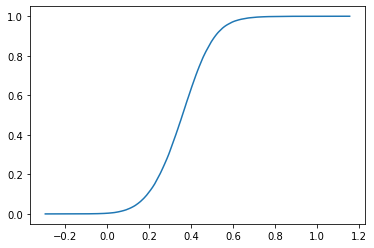

In [28]:
import sklearn.linear_model

ridge = sklearn.linear_model.Ridge(alpha=1)
ridge.fit(trainX, trainY)
p = ridge.predict(valX)
ecdf(p)
sklearn.metrics.roc_auc_score(valY, p)

In [14]:
import sklearn.model_selection

params = {
    "alpha": list(range(240,450,20))
}
gs = sklearn.model_selection.GridSearchCV(
    sklearn.linear_model.Ridge(), params, scoring="roc_auc"
)
gs.fit(trainX, trainY)

GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [240, 260, 280, 300, 320, 340, 360, 380, 400,
                                   420, 440]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

0.6562981225847518

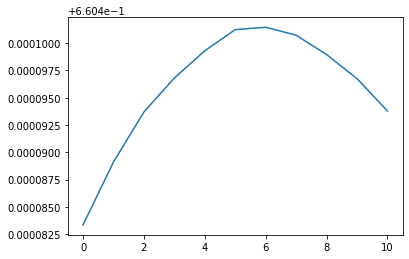

In [15]:
plt.plot(gs.cv_results_["mean_test_score"])
p = gs.predict(valX)
sklearn.metrics.roc_auc_score(valY, p)

## Predict

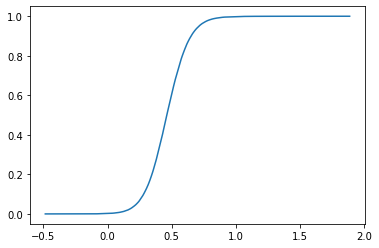

In [29]:
# fit on all data and predict
ridge = sklearn.linear_model.Ridge(alpha=200)
ridge.fit(ftrainX, ftrainY)
p = ridge.predict(ftestX)
ecdf(p)

In [30]:
# final output requires values in [0,1]
pscale = (p - np.min(p)) / (np.max(p)-np.min(p))
out = pd.DataFrame({"id":test_o.iloc[:,0], "Predicted":pscale})

with open("rdige-prepr-reg.csv", "w") as f:
    f.write(out.to_csv(index=False))